In [20]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn,autograd
from torchvision import transforms
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [21]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn.functional as F

In [22]:
images_path = '../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset'
captions_path = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr8k.token.txt'
train_path = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")


In [23]:
dict_ = {}  #empty dictionary

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in dict_:
        dict_[temp[0]].append(temp[1][2:])
    else:
        dict_[temp[0]] = [temp[1][2:]]

In [41]:


def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(x)
    t=tokenizer.texts_to_sequences(x)
    # TODO: Implement
    return t, tokenizer



In [47]:
def pad(x, length=80):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

In [42]:


def preprocess(sentences):
    text_tokenized, text_tokenizer = tokenize(sentences)
    text_pad = pad(text_tokenized)
    return text_pad, text_tokenizer



In [43]:
def load_image(name):
    img = image.load_img(name,target_size=(128,128,3))
    img = image.img_to_array(img)
#     img = img/255
    
    #plt.imshow(img)
#     img = np.reshape(img,(224*224*3))
    return img.T

In [45]:
image_arr=[]
sentence_arr=[]
i=0
for img in x_test:
    if img == '':
        continue
    for capt in dict_[img]:
        caption = "<SOS> "+ capt + " <EOS>"
        sentence_arr.append(caption)
    image_arr.append(img)
        
        

In [48]:
Sentence , token_Sentence = preprocess(sentence_arr)

In [26]:
Images =  np.array(image_arr)

## Custom architecture

In [27]:
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')
# cuda0 ='cpu'
# cuda1 = 'cpu'

In [28]:
# device = torch.device("cuda" if torch.cuda.device else "cpu")
# device='cpu'
#7819
vocab_size=7819
embedding_size = 512
batch_size=1
max_len_t = 80
patch_size=16
img_size=128
num_patches = (img_size * img_size) // patch_size**2 

In [29]:
vocab_size,max_len_t

(7819, 80)

In [30]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 512.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=512):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
#         self.flatten = nn.Flatten()
        
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)# only flatten the feature map dimensions into a single vector

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass 
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
#         print(x_flattened.shape)
#         print(x_flattened.permute(2,0,1).shape)
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(2,0,1) #.permute(0,2,1)

In [31]:
class encoder(nn.Module):
    def __init__(self, img_size=img_size,embedding_dim=512,patch_size=16,num_channels=3):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels=num_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim).to(cuda0)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=512,
                                                     nhead=4,
                                                     dim_feedforward=2048,
                                                     activation="gelu",
#                                                      batch_first=True,
#                                                      norm_first=True,
                                                     device=cuda0), # Create a single Transformer Encoder Layer
                                                     num_layers=2).to(cuda0)
        #creating positional embedding

        num_patches = (img_size * img_size) // patch_size**2 
        self.positional_embedding = nn.Parameter(torch.randn(num_patches,batch_size,embedding_dim)).to(cuda0)
        
        self.embedding_dropout = nn.Dropout(p=0.1).to(cuda0)
    def forward(self,images):
        
        batches = images.shape[0]
        x = self.patch_embedding(images)
#         print('patch embed',x.shape)
#         x = x[np.newaxis,0:].T
#         print('position embed',self.positional_embedding.shape)
        x = self.positional_embedding + x
        x.requires_grad_()
        trans_encoder = self.transformer_encoder(x)
        return trans_encoder#(1,0,2) 2 is the last index , 0 is the batchsize

In [32]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = encoder()
        self.trg_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len_t, embedding_size)
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=embedding_size,
                                                     nhead=4,
#                                                      batch_first=True,
                                                     activation='gelu',
#                                                      norm_first=True,
                                                     device=cuda0), 
                                                     num_layers=2).to(cuda0)
        self.out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(0.2).to(cuda0)
    
    def mask(self,sz):
        
        mask = (torch.triu(torch.ones(sz[0], sz[0])) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')). \
        masked_fill(mask == 1, float(0.0))
        return mask
  
        
    def forward(self,img,trg):
#         print(trg.shape)
#         print(type(trg))
#         print(self.trg_word_embedding)
        trg=trg.type(torch.int64)
        trg_seq_length,N = trg.shape
#         print('in gene',trg_seq_length)
        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length,N)
            
        ).to(cuda0)
#         print(trg_positions)

        embed_trg = self.dropout(
                self.trg_word_embedding(trg) +
                 self.trg_position_embedding(trg_positions)
            )
        in_features = self.encoder(img)
#         print('the shape of mat from encoder is ',in_features.shape,
#               '\n embeded trg',embed_trg.shape)
        in_features.requires_grad_()
        trg_mask = self.mask(trg.shape).to(cuda0)
        logits = self.transformer_decoder(embed_trg,in_features,tgt_mask=trg_mask) #in_features is from the encoder
        
        logits = self.out(logits)
#         print(logits.shape)
        return logits

In [33]:
def create_batch(src, tar , batchsize , i):
    

    src=  src[(i-1)*batchsize : (i-1)*batchsize + batchsize]
    tar =tar[(1-1)*batchsize : (1-1)*batchsize + batchsize]
#     print(tar.shape)
    return torch.tensor(src).float(),torch.tensor(tar).T.long()

In [34]:
c = torch.load('/kaggle/input/flicker-pretrained/c_flicker5.h5').to(cuda0)
c

generator(
  (encoder): encoder(
    (patch_embedding): PatchEmbedding(
      (patcher): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
      (flatten): Flatten(start_dim=2, end_dim=3)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadA

In [51]:
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')
c_device = next(c.parameters()).device

## Evaluation 

### For diversity lets use n-gram diversity and for similarity lets use BLEU score and CIDEr

In [36]:
def display_image(name):
    img = image.load_img(name,target_size=(512,512,3))
    img = image.img_to_array(img)
    img = img/255
    plt.imshow(img)

In [62]:
from nltk.translate.bleu_score import sentence_bleu
def evaluate(loc):
    image_loc = images_path+'/'+str(loc)
    
    sent = dict_[loc]
    image_arr = []
    img = load_image(image_loc)
    image_arr.append(img)
    img_arr = np.array(image_arr)
    sentence = []
    sentence.append(sent[0])
    sentence[0] = '<SOS> '+sentence[0]+'<EOS>'
    sentence = pad(token_Sentence.texts_to_sequences(sentence) , length = 80)
    src , tar = create_batch(img_arr,sentence, 1,1)
    src = src.to(c_device)
    tar = tar.to(c_device)
    c.eval()
    output =  c(src,tar)
    src.detach()
    tar.detach()
#     loss = criterion(output.view(-1, output.shape[2]), tar.reshape(-1))
    sentence_formed = ''
    val, ind = torch.max(output.view(-1, output.shape[2]), 1)
    for word in ind:
        #print('--->'+sentence_formed+'    '+str(word.item()))
        if word.item() == 3: # EOS
                break
        for key, value in token_Sentence.word_index.items():
            #print(value == word.item()) 
            if value == word.item() and value != 2: # sos
                sentence_formed = sentence_formed + key +' '
                break
    display_image(image_loc)
#     print('loss = ',loss)
#     print(output)
    
    print('Individual 1-gram: %f' % sentence_bleu(sent[0].split(), sentence_formed.split(), weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(sent[0].split(), sentence_formed.split(), weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(sent[0].split(), sentence_formed.split(), weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(sent[0].split(), sentence_formed.split(), weights=(0, 0, 0, 1)))
    score = sentence_bleu(sent[0].split(), sentence_formed.split(),weights=(0.25, 0.5, 0.15, 0.10))
    print('Orginal ->',sent[0])
    print('Bleu Score is {}'.format(score))
    print('other original sentences are \n', sent)
    print('Sentence formed ->',sentence_formed)
    return [sentence_formed , sent]

Individual 1-gram: 0.090909
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> The dogs are in the snow in front of a fence .
Bleu Score is 0.5491004867761125
other original sentences are 
 ['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .']
Sentence formed -> the dogs are in the snow in front of a fence 


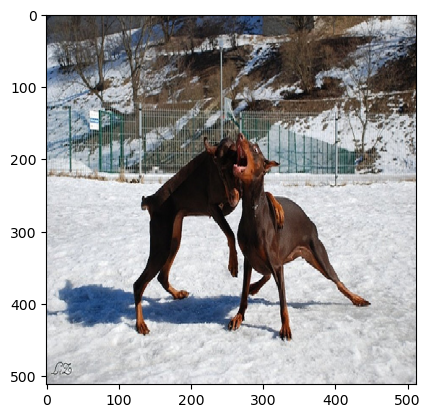

In [63]:
s,o=evaluate(Images[0])

Individual 1-gram: 0.111111
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> A girl wets her head in a white bucket .
Bleu Score is 0.5773502691896257
other original sentences are 
 ['A girl wets her head in a white bucket .', 'A little girl dips her hair into a bucket filled with water .', 'A little girl has dunked her head in a bowl of water .', 'A little girl in a dress lifts her soaked head from a bucket .', 'a young girl lifting her wet hair out of a white bucket']
Sentence formed -> a girl wets her head in a white bucket 


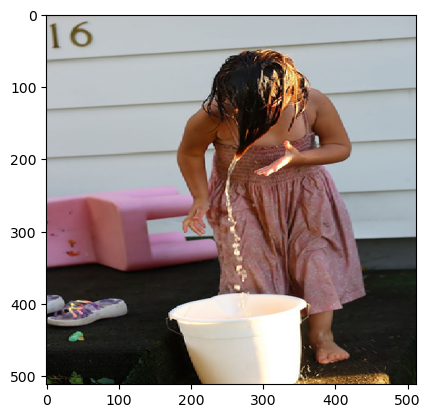

In [70]:
s,o=evaluate(Images[200])

Individual 1-gram: 0.153846
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> A boy wearing a teal shirt is riding a skateboard on a sidewalk .
Bleu Score is 0.6262844962765469
other original sentences are 
 ['A boy wearing a teal shirt is riding a skateboard on a sidewalk .', 'A man wearing a green shirt is skateboarding on a ramp beside a white fence .', 'A skateboarder in a light green shirt .', 'A young male wearing a blue shirt rides a skateboard in an outdoor park at night .', 'A young man skateboards at night by a fence .']
Sentence formed -> a boy wearing a teal shirt is riding a skateboard on a sidewalk 


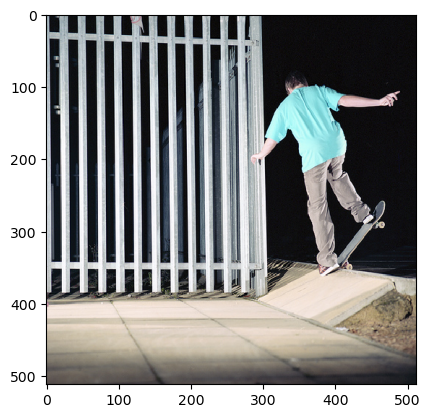

In [71]:
s,o=evaluate(Images[600])

In [ ]:
d={}
for loc in Images:
    m,o = evaluate(loc)
    d[m]=o


Individual 1-gram: 0.090909
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> The dogs are in the snow in front of a fence .
Bleu Score is 0.5491004867761125
other original sentences are 
 ['The dogs are in the snow in front of a fence .', 'The dogs play on the snow .', 'Two brown dogs playfully fight in the snow .', 'Two brown dogs wrestle in the snow .', 'Two dogs playing in the snow .']
Sentence formed -> the dogs are in the snow in front of a fence 
Individual 1-gram: 0.090909
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000
Orginal -> a brown and white dog swimming towards some in the pool
Bleu Score is 0.5491004867761125
other original sentences are 
 ['a brown and white dog swimming towards some in the pool', 'A dog in a swimming pool swims toward sombody we cannot see .', 'A dog swims in a pool near a person .', 'Small dog is paddling through the water in a pool .', 'The small brown and white dog is

KeyboardInterrupt: 

In [ ]:
import pickle



# save dictionary to person_data.pkl file
with open('sentence.pkl', 'wb') as fp:
    pickle.dump(d, fp)
    print('dictionary saved successfully to file')